# model.ipynb: 示例代码，建立决策树
这是示例代码，目的是为了让您更好地了解我们的算法。

方便起见，本notebook中只用了一个训练集，即`final-2.h5`。如果要使用全部的训练集，请参见`train.ipynb`。

为了能够更加清晰地展现出数据的处理过程，这里不用先跑预处理数据的代码`waveform.py`，而会将对数据的预处理放在代码块中。

本notebook的任务是训练出决策树，目标是每个事件的动量p，即`modelPCalc.txt`。

训练完之后，运行`final.ipynb`，便可以得到最终的答案。

可以将建立决策树的过程分为以下几步：
1. 读取训练集；
2. 对波形进行除噪声处理；
3. 使用波形，找到每个波形对应的PE总数，以及PETime平均值；
4. 每个事件都有很多波形，这些波形都有各自对应的PE总数和PETime平均值。对这些数据，按照事件做如下处理：
    - PE总数对每个事件求和；
    - PE总数对每个事件求平均值；
    - PE总数对每个事件求标准差；
    - PETime平均值对每个事件求平均值；
    - PETime平均值对每个事件求标准差；
5. 使用4中得到的5个特征，训练到动量`p`的决策树。

下面也按照这五步的顺序，展示相应的代码。

In [1]:
import multiprocessing
import warnings # 临时需要，没有的话有一步代码会疯狂报/0的warning，其实这是正常情况
import numpy as np
import h5py
import matplotlib.pyplot as plt
%matplotlib inline
from utils import loadData, getNum, getPePerWF, lossfunc_train, lossfunc_eval
from tqdm import tqdm # 展示进度条
import lightgbm as lgb # 训练决策树使用的包
# %load_ext line_profiler

### 1. 读取训练集

先指定训练集的位置`trainPath`，本示例代码中只使用了一个数据集`final-2.h5`。git仓库中并没有数据集，需要先跑`fetch.sh`，或者执行`make data`。

所有的文件读取操作均由`utils.py`中的`loadData`函数实现。

读取训练集可能需要一分钟左右。结束后会展示读进来的三个表的信息。

In [2]:
trainPath = "./data/final-2.h5" # 指定训练集位置

# %lprun -f loadData loadData(trainPath, 'PT')

# trainPET是PETruth表，trainWF是Waveform表，trainPT是ParticleTruth表
trainPET, trainWF, trainPT = loadData(trainPath, 'PT')

Structure of data:
<HDF5 dataset "PETruth": shape (9137011,), type "|V20"> PETruth /PETruth
<HDF5 dataset "ParticleTruth": shape (2000,), type "|V40"> ParticleTruth /ParticleTruth
<HDF5 dataset "Waveform": shape (6041164,), type "|V2008"> Waveform /Waveform


  0%|          | 0/16 [00:00<?, ?it/s]

正在读取data


100%|██████████| 16/16 [00:38<00:00,  2.41s/it]


(6041164,)


## 2. 对波形进行去噪声处理
设置下限为918，小于918的认为是有意义的信息，大于等于918的认为是噪声，置为0。

这里波形的数据是反过来的，因此再用918去减有意义的信息，得到去噪之后的波形。

这可以去除绝大部分没有PE处的暗噪声，但有PE处的暗噪声不能被去除。

In [3]:
denoisedTrainWF = np.where(trainWF['Waveform'] < 918, 918-trainWF['Waveform'], 0)

## 3. 使用波形，找到每个波形对应的PE总数，以及PETime平均值

这里使用了手作算法，`getPePerWF`函数。函数的具体实现位于`utils.py`中。算法的大致思路如下（下面的“波形”均指去噪后的波形）：
1. 将PE总数置为0，将PETime总数置为0。如果一个波形，纵坐标超过0的点的数量小于4，则不进行2-7；
2. 对一个波形，执行`np.argmax`，找到最大值对应的index后，认为这是一次PE所在的位置；
3. 将波形减去一个峰值在argmax处的取消函数（表示一个PE产生的效果），这里简单地取峰值是18，宽度是16的三角单脉冲波；
4. 对一个波形，在历史上取过的所有取消函数不为0的区域，判断纵坐标是否小于8，如果是则认为是噪声造成的，置为0；
5. 计算减去后的波形的积分，以及纵坐标超过0的点的数量；
6. 如果$150 \leq \text{argmax} \leq 600$，则PE总数+1，PETime总数+argmax;
7. 重复2-6的操作，直到波形的积分小于$150-8\text{max}\{\text{超过0的点数量}, 16-\text{超过0的点数量}\}$；
8. 返回PE总数，以及PETime总数/PE总数

手作算法中使用了波形积分以及纵坐标超过0的点的数量。我们可以通过下面的代码获取这两个值：

In [4]:
intTrainWF = np.sum(denoisedTrainWF, axis=1)
pointsPerTrainWF = np.sum(denoisedTrainWF > 0, axis=1)

为了检验手作算法的效果，需要得到每个waveform对应的pe数`pePerTrainWF`，作为真值。这里需要将EventID与ChannelID相同的行并列起来。但由于有暗触发的问题，又需要把没有PE的波形单独找出来。

为了方便以后的实现，我们先将属于一个Event的PE分开。这里调用了`utils.py`中定义的`getNum`函数。得到的`peIndices`是一个$(n+1,)$的ndarray，$n$表示训练集的EventID数。当$i<n$时，`peIndices[i]`表示EventID为$i$对应第一个PE的下标；当$i=n$时，`peIndices[i]`表示训练集PETruth表的总行数。`wfIndices`是类似的。

为什么要$n+1$呢？~历史上是因为这样能更方便地得到`numPET`~因为如果需要将18个训练集拼接成一个训练集，就会方便很多。详见`train.ipynb`。

`numPET`与`numPEW`是$(n,)$的ndarray，下标为$i$各表示EventID为$i$时的PE数和波形数。这两个变量后面并没有用到，因为历史原因保留在这里。

In [5]:
numPET, peIndices = getNum(trainPET)
numPEW, wfIndices = getNum(trainWF)

在这之后，将同一事件的waveform和PETruth分开，分别按照ChannelID进行`np.unique`，我们便可以得到`pePerTrainWF`了。

In [6]:
pePerTrainWF = np.array([], dtype=int)
splitWFChannels = np.split(trainWF['ChannelID'], wfIndices[1:-1])
for index, arr in enumerate(tqdm(np.split(trainPET['ChannelID'], peIndices[1:-1]))):
    channels, counts = np.unique(arr, return_counts=True)
    
    # 上面得到的counts并不能直接用，因为需要为暗触发的waveform补0

    # 使用isin得到counts虽然很简洁，但似乎略慢于傻傻地使用while，原因不明。
    # indicesToInsert = np.isin(splitWFChannels[index], channels, invert=True).nonzero()[0]
    # for indexToInsert in indicesToInsert:
        # counts = np.insert(counts, indexToInsert, 0) #注意不能一次性insert了，要用for循环，因为可能会越界访问。

    zeroPeChannelCount = numPEW[index].astype(int) - channels.shape[0]
    while zeroPeChannelCount:
        alignedChannels = np.append(channels, np.zeros(zeroPeChannelCount)-1)
        indexToInsert = np.asarray(alignedChannels != splitWFChannels[index]).nonzero()[0][0]
        channels = np.insert(channels, indexToInsert, splitWFChannels[index][indexToInsert])
        counts = np.insert(counts, indexToInsert, 0)
        zeroPeChannelCount -= 1
    
    pePerTrainWF = np.append(pePerTrainWF, counts)

pePerTrainWF = pePerTrainWF.flatten().astype(int)
# peTimesPerTrainWF = np.split(trainPET['PETime'], np.cumsum(pePerTrainWF))[:-1]

100%|██████████| 2000/2000 [00:17<00:00, 116.77it/s]


下面检验手作算法的效果。这里的代码会随机在训练集中取两个波形，让`getPePerWF`进行分析，并且打印出结果，波形对应的积分，超过0的点数量，正确的`pePerTrainWF`，以及画出波形的图像。

PE真值是[1 1]
积分是[ 73 103]
超出阈值的点是[16 19]
手作算法返回值为[[  1.   1.]
 [432. 311.]]


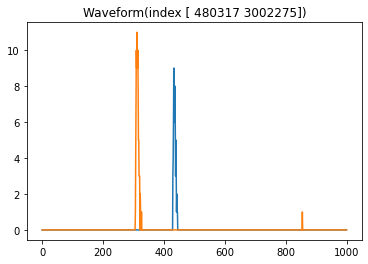

In [7]:
randIndex = np.random.randint(0, denoisedTrainWF.shape[0]-1,2) # 随机取两个波形
# %lprun -f getPePerWF getPePerWF(denoisedTrainWF[randIndex])
res = getPePerWF(denoisedTrainWF[randIndex])
print(f"PE真值是{pePerTrainWF[randIndex]}")
print(f"积分是{intTrainWF[randIndex]}")
print(f"超出阈值的点是{pointsPerTrainWF[randIndex]}")
print(f"手作算法返回值为{res}")
plt.plot(denoisedTrainWF[randIndex][0])
plt.plot(denoisedTrainWF[randIndex][1])
plt.title(f"Waveform(index {randIndex})")
plt.show()

这是正式处理训练集的代码。

注意，如果没有`warnings.simplefilter("ignore")`，会导致疯狂报0/0的warning。这是由于一个waveform可能全是暗噪声，或者根本就是暗触发，导致手作算法根本没有运行argmax（这也是正确的表现）。后面的代码会处理nan，所以这里忽略warning。

In [8]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    chunkNum = 100
    splitDenoisedTrainWF = np.array_split(denoisedTrainWF, chunkNum)
    with multiprocessing.Pool(8) as pool:
        res = np.concatenate(list(tqdm(
                                pool.imap(
                                    getPePerWF,
                                    splitDenoisedTrainWF
                                ),
                                total=chunkNum
                                )),
                            axis=1)
        pePerTrainWFCalc, meanPeTimePerTrainWF = res

100%|██████████| 100/100 [00:37<00:00,  2.70it/s]


下面检验`pePerTranWFCalc`与真正的`pePerTrainWF`的关系，画出散点图。

可以看到，两者大致在一直线上，斜率略大于1。

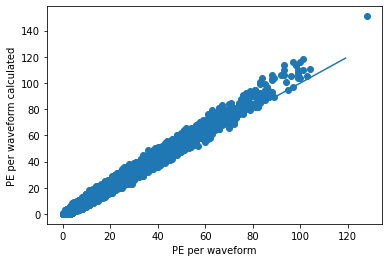

In [9]:
plt.scatter(pePerTrainWF, pePerTrainWFCalc)
plt.xlabel("PE per waveform")
plt.ylabel("PE per waveform calculated")
plt.plot(np.arange(120), np.arange(120))
plt.show()

## 4. 对PE总数与PETime平均值，按照事件进行处理
目标是以下五个值：
- PE总数对每个事件求和；
- PE总数对每个事件求平均值；
- PE总数对每个事件求标准差；
- PETime平均值对每个事件求平均值；
- PETime平均值对每个事件求标准差；

将属于不同事件的`pePerTrainWFFinal`分开，然后得到这五个feature。

除此之外，从`trainPT`中读取目标`p`

In [10]:
splitPePerTrainWFFinal = np.split(pePerTrainWFCalc, wfIndices[1:-1].astype(int))
p = trainPT['p']
peTotal = np.empty(p.shape[0])
peMean = np.empty(p.shape[0])
peStd = np.empty(p.shape[0])
for index, pePerTrainWFFinalChunk in enumerate(tqdm(splitPePerTrainWFFinal)):
    peTotal[index] = np.sum(pePerTrainWFFinalChunk)
    peMean[index] = np.mean(pePerTrainWFFinalChunk)
    peStd[index] = np.std(pePerTrainWFFinalChunk)

splitMeanPeTimePerTrainWF = np.split(meanPeTimePerTrainWF, wfIndices[1:-1])
peTimeMean = np.empty(p.shape[0])
peTimeStd = np.empty(p.shape[0])
for index, meanPeTimePerTrainWFFinalChunk in enumerate(tqdm(splitMeanPeTimePerTrainWF)):
    peTimeMean[index] = np.nanmean(meanPeTimePerTrainWFFinalChunk)
    peTimeStd[index] = np.nanstd(meanPeTimePerTrainWFFinalChunk)


100%|██████████| 2000/2000 [00:00<00:00, 5323.64it/s]


## 5. 使用4中得到的5个特征，训练到动量`p`的决策树。
使用`lightgbm`，先创造训练集与验证集，使用后200个数据作为验证集，之前的数据作为训练集；然后按照参数训练决策树，存储到`./model/modelPCalc.txt`中。

In [11]:
trainDataForP = lgb.Dataset(
    np.stack(
        (peTotal[:-200], peMean[:-200], peStd[:-200], peTimeMean[:-200], peTimeStd[:-200]),
        axis=1
    ),
    label=p[:-200]
)
validationDataForP = lgb.Dataset(
    np.stack(
        (peTotal[-200:], peMean[-200:], peStd[-200:], peTimeMean[-200:], peTimeStd[-200:]),
        axis=1
    ),
    label=p[-200:],
    reference=trainDataForP
)
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'custom'},
    'num_leaves': 2**10,
    'learning_rate': 0.01,
    'feature_fraction': 1,
    'bagging_fraction': 0.1,
    'bagging_freq': 5,
    'verbose': 0,
    'num_threads': 20,
    'max_depth': 10,
}
gbmForP = lgb.train(
    params,
    trainDataForP,
    num_boost_round=60000,
    valid_sets=validationDataForP,
    early_stopping_rounds=1000,
    fobj=lossfunc_train,
    feval=lossfunc_eval
)
gbmForP.save_model('./model/modelPCalc.txt')

[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	valid_0's custom: 5.34591
Training until validation scores don't improve for 1000 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2]	valid_0's custom: 5.24192
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3]	valid_0's custom: 5.14001
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	valid_0's custom: 5.04014
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[5]	valid_0's custom: 4.94226
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[6]	valid_0's custom: 4.84682
[LightGBM] [Warning] No 

[186]	valid_0's custom: 0.171539
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[187]	valid_0's custom: 0.168862
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[188]	valid_0's custom: 0.166241
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[189]	valid_0's custom: 0.163675
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[190]	valid_0's custom: 0.161164
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[191]	valid_0's custom: 0.158439
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[192]	valid_0's custom: 0.15577
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[193]	valid_0's custom: 0.153158
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[194]	valid_0's custom: 0.1506
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[195]	valid_0's custom: 0.14809

[389]	valid_0's custom: 0.0236404
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[390]	valid_0's custom: 0.0235697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[391]	valid_0's custom: 0.0234809
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[392]	valid_0's custom: 0.0233944
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[393]	valid_0's custom: 0.0233102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[394]	valid_0's custom: 0.0232281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[395]	valid_0's custom: 0.0231481
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[396]	valid_0's custom: 0.0230436
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[397]	valid_0's custom: 0.0229411
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[398]	valid_0's cus

[593]	valid_0's custom: 0.0165459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[594]	valid_0's custom: 0.0165582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[595]	valid_0's custom: 0.0165588
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[596]	valid_0's custom: 0.0165568
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[597]	valid_0's custom: 0.0165556
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[598]	valid_0's custom: 0.0165535
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[599]	valid_0's custom: 0.0165536
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[600]	valid_0's custom: 0.0165528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[601]	valid_0's custom: 0.0165341
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[602]	valid_0's cus

[792]	valid_0's custom: 0.016606
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[793]	valid_0's custom: 0.0165842
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[794]	valid_0's custom: 0.0165638
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[795]	valid_0's custom: 0.0165446
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[796]	valid_0's custom: 0.0165544
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[797]	valid_0's custom: 0.0165647
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[798]	valid_0's custom: 0.0165754
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[799]	valid_0's custom: 0.0165866
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[800]	valid_0's custom: 0.0165989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[801]	valid_0's cust

[987]	valid_0's custom: 0.0166531
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[988]	valid_0's custom: 0.0166191
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[989]	valid_0's custom: 0.0165846
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[990]	valid_0's custom: 0.0165553
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[991]	valid_0's custom: 0.0165753
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[992]	valid_0's custom: 0.0165954
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[993]	valid_0's custom: 0.0166155
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[994]	valid_0's custom: 0.0166357
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[995]	valid_0's custom: 0.0166558
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[996]	valid_0's cus

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1185]	valid_0's custom: 0.016372
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1186]	valid_0's custom: 0.016367
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1187]	valid_0's custom: 0.0163624
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1188]	valid_0's custom: 0.0163581
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1189]	valid_0's custom: 0.0163541
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1190]	valid_0's custom: 0.0163504
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1191]	valid_0's custom: 0.0163015
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1192]	valid_0's custom: 0.016254
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1193]	valid_0's custom: 0.0162079
[LightGBM] [W

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1381]	valid_0's custom: 0.0157881
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1382]	valid_0's custom: 0.0157868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1383]	valid_0's custom: 0.0157857
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1384]	valid_0's custom: 0.0157912
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1385]	valid_0's custom: 0.0157969
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1386]	valid_0's custom: 0.0158082
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1387]	valid_0's custom: 0.0158199
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1388]	valid_0's custom: 0.0158318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1389]	valid_0's custom: 0.015844
[LightGBM] 

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1579]	valid_0's custom: 0.0152611
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1580]	valid_0's custom: 0.0152856
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1581]	valid_0's custom: 0.0152615
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1582]	valid_0's custom: 0.015238
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1583]	valid_0's custom: 0.015215
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1584]	valid_0's custom: 0.0151925
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1585]	valid_0's custom: 0.0151706
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1586]	valid_0's custom: 0.0151627
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1587]	valid_0's custom: 0.0151551
[LightGBM] [

[1790]	valid_0's custom: 0.0152494
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1791]	valid_0's custom: 0.0152555
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1792]	valid_0's custom: 0.0152617
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1793]	valid_0's custom: 0.0152708
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1794]	valid_0's custom: 0.01528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1795]	valid_0's custom: 0.0152868
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1796]	valid_0's custom: 0.0152618
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1797]	valid_0's custom: 0.0152374
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1798]	valid_0's custom: 0.0152236
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1799]	valid

[2001]	valid_0's custom: 0.0155211
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2002]	valid_0's custom: 0.015524
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2003]	valid_0's custom: 0.015527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2004]	valid_0's custom: 0.0155301
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2005]	valid_0's custom: 0.0155334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2006]	valid_0's custom: 0.0155212
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2007]	valid_0's custom: 0.0155095
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2008]	valid_0's custom: 0.0154981
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2009]	valid_0's custom: 0.0154873
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2010]	valid

[2213]	valid_0's custom: 0.0151669
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2214]	valid_0's custom: 0.0151619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2215]	valid_0's custom: 0.0151571
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2216]	valid_0's custom: 0.0151399
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2217]	valid_0's custom: 0.0151227
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2218]	valid_0's custom: 0.0151061
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2219]	valid_0's custom: 0.0150901
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2220]	valid_0's custom: 0.0150755
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2221]	valid_0's custom: 0.0150911
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2222]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2422]	valid_0's custom: 0.014838
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2423]	valid_0's custom: 0.014859
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2424]	valid_0's custom: 0.0148724
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2425]	valid_0's custom: 0.0148861
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2426]	valid_0's custom: 0.0148717
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2427]	valid_0's custom: 0.0148576
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2428]	valid_0's custom: 0.0148437
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2429]	valid_0's custom: 0.0148268
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2430]	valid_0's custom: 0.0148102
[LightGBM] [

[2631]	valid_0's custom: 0.0144545
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2632]	valid_0's custom: 0.0144527
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2633]	valid_0's custom: 0.014451
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2634]	valid_0's custom: 0.0144495
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2635]	valid_0's custom: 0.0144482
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2636]	valid_0's custom: 0.0144424
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2637]	valid_0's custom: 0.0144369
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2638]	valid_0's custom: 0.0144318
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2639]	valid_0's custom: 0.014427
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2640]	valid

[2844]	valid_0's custom: 0.014877
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2845]	valid_0's custom: 0.0148499
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2846]	valid_0's custom: 0.0148388
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2847]	valid_0's custom: 0.014828
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2848]	valid_0's custom: 0.0148189
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2849]	valid_0's custom: 0.0148097
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2850]	valid_0's custom: 0.0147946
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2851]	valid_0's custom: 0.0147884
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2852]	valid_0's custom: 0.0147845
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[2853]	valid

[3052]	valid_0's custom: 0.0149889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3053]	valid_0's custom: 0.0149966
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3054]	valid_0's custom: 0.0150044
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3055]	valid_0's custom: 0.0150123
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3056]	valid_0's custom: 0.0149951
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3057]	valid_0's custom: 0.0149783
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3058]	valid_0's custom: 0.0149619
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3059]	valid_0's custom: 0.0149459
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3060]	valid_0's custom: 0.0149303
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3061]	val

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3258]	valid_0's custom: 0.0150629
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3259]	valid_0's custom: 0.0150674
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3260]	valid_0's custom: 0.0150725
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3261]	valid_0's custom: 0.0150697
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3262]	valid_0's custom: 0.015067
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3263]	valid_0's custom: 0.0150644
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3264]	valid_0's custom: 0.015062
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3265]	valid_0's custom: 0.0150597
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3266]	valid_0's custom: 0.0150277
[LightGBM] [

[3454]	valid_0's custom: 0.0155826
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3455]	valid_0's custom: 0.0155572
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3456]	valid_0's custom: 0.0155472
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3457]	valid_0's custom: 0.0155375
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3458]	valid_0's custom: 0.0155281
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3459]	valid_0's custom: 0.015519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3460]	valid_0's custom: 0.0155102
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3461]	valid_0's custom: 0.0155104
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3462]	valid_0's custom: 0.0155207
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3463]	vali

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3661]	valid_0's custom: 0.016008
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3662]	valid_0's custom: 0.0160019
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3663]	valid_0's custom: 0.0159948
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3664]	valid_0's custom: 0.015989
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3665]	valid_0's custom: 0.0159823
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3666]	valid_0's custom: 0.0159812
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3667]	valid_0's custom: 0.0159802
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3668]	valid_0's custom: 0.0159641
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[3669]	valid_0's custom: 0.0159634
[LightGBM] [

下面来观察一下决策树的预测能力。使用决策树，将全体数据输入，让其预测`p`，并与真值相比较，画出散点图。

print的tuple表示五个特征在决策树中起到的作用大小。

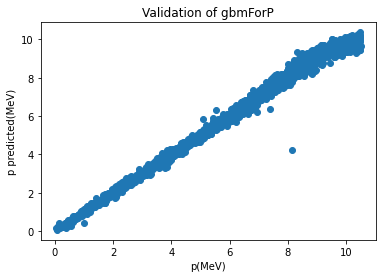

[5495 3120 3040 2942 4772]


In [12]:
plt.scatter(
    p,
    gbmForP.predict(
        np.stack(
            (peTotal, peMean, peStd, peTimeMean, peTimeStd),
            axis=1
        )
    )
)
plt.xlabel("p(MeV)")
plt.ylabel("p predicted(MeV)")
plt.title("Validation of gbmForP")
plt.show()
print(gbmForP.feature_importance())

最后，跑一遍`final.ipynb`，得到结果。这里只用到了一个训练集，因此效果会差于使用所有训练集训练出的决策树。